In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10, 'lines.linewidth': 2})

In [2]:
def lax_friedrichs(initial_conditions, nu, flux_function, num_steps):
    space_dim = len(initial_conditions)
    time_dim = num_steps + 1
    u_values = np.zeros((space_dim, time_dim))
    u_values[:, 0] = initial_conditions
    
    for n in range(num_steps):
        u_values[:, n+1] = (np.roll(u_values[:, n], 1) + np.roll(u_values[:, n], -1)) / 2 \
                            - nu * (flux_function(np.roll(u_values[:, n], -1)) - flux_function(np.roll(u_values[:, n], 1))) / 2
    return u_values

In [3]:
def richtmeyer(initial_conditions, nu, flux_function, num_steps):
    space_dim = len(initial_conditions)
    time_dim = num_steps + 1
    u_values = np.zeros((space_dim, time_dim))
    u_values[:, 0] = initial_conditions
    
    for n in range(num_steps):
        u_half = (u_values[:, n] + np.roll(u_values[:, n], -1)) / 2 \
                 - nu * (flux_function(np.roll(u_values[:, n], -1)) - flux_function(u_values[:, n])) / 2
        u_values[:, n+1] = u_values[:, n] - nu * (flux_function(u_half) - flux_function(np.roll(u_half, 1)))
    
    return u_values

In [4]:
def maccormack(initial_conditions, nu, flux_function, num_steps):
    space_dim = len(initial_conditions)
    time_dim = num_steps + 1
    u_values = np.zeros((space_dim, time_dim))
    u_values[:, 0] = initial_conditions
    
    for n in range(num_steps):
        u_star = u_values[:, n] - nu * (flux_function(u_values[:, n]) - flux_function(np.roll(u_values[:, n], 1)))
        u_values[:, n+1] = (u_values[:, n] + u_star) / 2 \
                            - nu * (flux_function(u_star) - flux_function(np.roll(u_star, 1))) / 2
    return u_values

In [5]:
def godunov(initial_conditions, nu, flux_function, num_steps):
    space_dim = len(initial_conditions)
    time_dim = num_steps + 1
    u_values = np.zeros((space_dim, time_dim))
    u_values[:, 0] = initial_conditions
    
    for n in range(num_steps):
        f_values = np.zeros(space_dim)
        u_roll = np.roll(u_values[:, n], -1)
        
        for j in range(space_dim):
            u_left = u_values[j, n]
            u_right = u_roll[j]
            if u_left <= u_right:
                if u_left < 0 and u_right > 0:
                    f_values[j] = flux_function(0)
                else:
                    f_values[j] = min(flux_function(u_left), flux_function(u_right))
            else:
                f_values[j] = max(flux_function(u_left), flux_function(u_right))
        
        u_values[:, n+1] = u_values[:, n] - nu * (f_values - np.roll(f_values, 1))
    
    return u_values

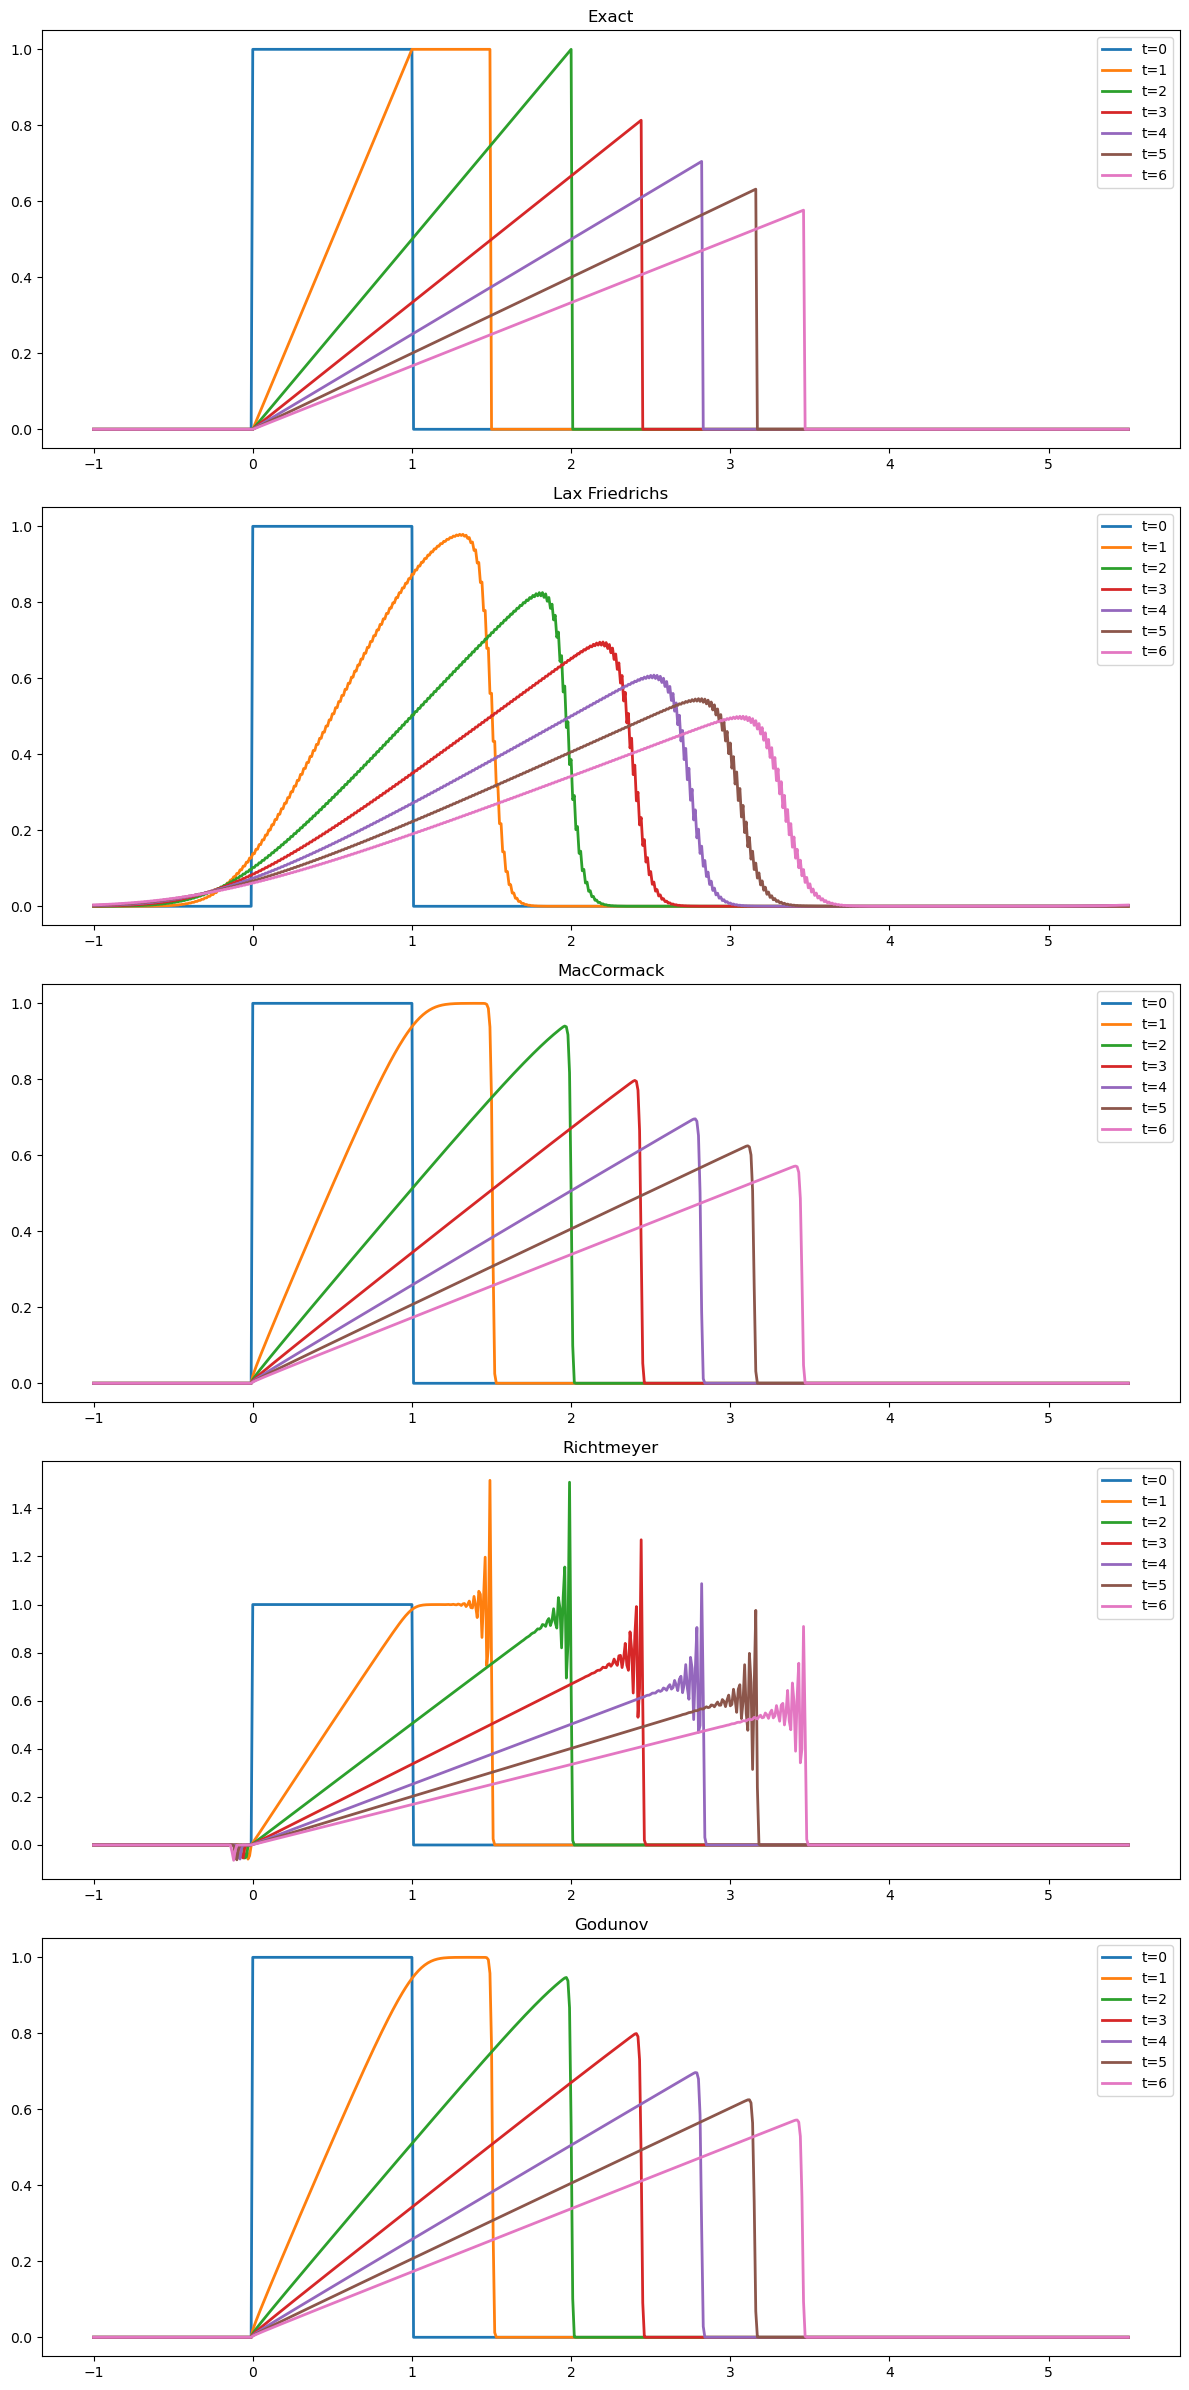

In [6]:
initial_condition = lambda x: (x >= 0) * (x <= 1)
flux_function = lambda x: x**2 / 2
exact_solution = lambda x, t: (x / t * (x >= 0) * (x <= t) + (x > t) * (x < (1 + t / 2))) * (t <= 2) \
                               + (x / t * (x >= 0) * (x <= np.sqrt(2 * t))) * (t > 2)

h = 0.01
nu = 1 / 4
k = h * nu

x_values = np.around(np.arange(-1, 5.5 + h, h), decimals=3)
t_values = np.around(np.arange(0, 6 + k, k), decimals=3)
num_steps = round(6 / k)

fig, ax = plt.subplots(5, 1, figsize=(12, 24))

# Plotting exact solution
ax[0].plot(x_values, initial_condition(x_values))
for i in range(1, 7):
    ax[0].plot(x_values, exact_solution(x_values, i))

# Plotting numerical solutions
for row, method in enumerate([lax_friedrichs, maccormack, richtmeyer, godunov]):
    solution = method(initial_condition(x_values), nu, flux_function, num_steps)

    for i in range(7):
        index = round(i * num_steps / 6)
        ax[row + 1].plot(x_values, solution[:, index])

# Setting titles and legends
titles = ['Exact', 'Lax Friedrichs', 'MacCormack', 'Richtmeyer', 'Godunov']
for row, title in enumerate(titles):
    ax[row].set_title(title)
    ax[row].legend(['t=0', 't=1', 't=2', 't=3', 't=4', 't=5', 't=6'])

plt.tight_layout()